<a href="https://colab.research.google.com/github/iris-kurapaty/Batch-Normalization/blob/main/Batch_Normalization_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
pwd

'/content'

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torchsummary import summary
from tqdm import tqdm
from model import *
from utils import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

100%|██████████| 170498071/170498071 [00:05<00:00, 29361872.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
torch.Size([3, 32, 32, 50000])
tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])
frog


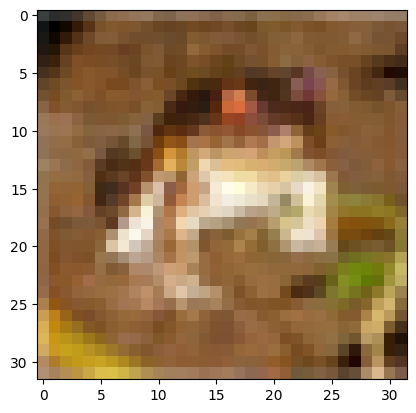

In [3]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor()) #
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor()) #

imgs = torch.stack([img_t for img_t, _ in train_data], dim=3)
print(imgs.shape)
print(imgs.view(3, -1).mean(dim=1))
print(imgs.view(3, -1).std(dim=1))

img, label =train_data[0]

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(label_names[label])

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      # transforms.Resize((28, 28)),
                                      # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([128, 3, 32, 32])
torch.Size([128])


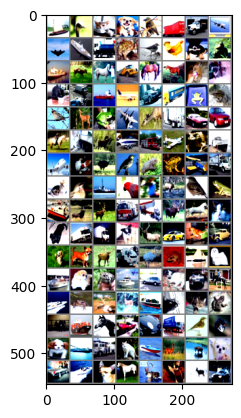

In [7]:
batch_size = 128
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


# Model Params for Group Normalization


In [82]:
from model import GN_Net

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = GN_Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
         GroupNorm-2           [-1, 16, 30, 30]              32
           Dropout-3           [-1, 16, 30, 30]               0
              ReLU-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 32, 28, 28]           4,608
         GroupNorm-6           [-1, 32, 28, 28]              64
           Dropout-7           [-1, 32, 28, 28]               0
              ReLU-8           [-1, 32, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             256
             ReLU-10            [-1, 8, 28, 28]               0
        MaxPool2d-11            [-1, 8, 14, 14]               0
           Conv2d-12           [-1, 16, 14, 14]           1,152
        GroupNorm-13           [-1, 16, 14, 14]              32
          Dropout-14           [-1, 16,

# Training and Testing for Group Normalization

In [83]:
train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []

model =  GN_Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.6207882165908813 Batch_id=390 Accuracy=28.33: 100%|██████████| 391/391 [00:19<00:00, 19.63it/s]



Test set: Average loss: 1.6624, Accuracy: 3819/10000 (38.19%)

EPOCH: 1


Loss=1.5526363849639893 Batch_id=390 Accuracy=42.90: 100%|██████████| 391/391 [00:19<00:00, 20.24it/s]



Test set: Average loss: 1.4043, Accuracy: 4778/10000 (47.78%)

EPOCH: 2


Loss=1.3919789791107178 Batch_id=390 Accuracy=49.39: 100%|██████████| 391/391 [00:21<00:00, 18.61it/s]



Test set: Average loss: 1.2663, Accuracy: 5383/10000 (53.83%)

EPOCH: 3


Loss=1.2094662189483643 Batch_id=390 Accuracy=53.29: 100%|██████████| 391/391 [00:20<00:00, 18.95it/s]



Test set: Average loss: 1.1821, Accuracy: 5722/10000 (57.22%)

EPOCH: 4


Loss=1.1242671012878418 Batch_id=390 Accuracy=56.27: 100%|██████████| 391/391 [00:19<00:00, 20.32it/s]



Test set: Average loss: 1.1888, Accuracy: 5766/10000 (57.66%)

EPOCH: 5


Loss=1.0483266115188599 Batch_id=390 Accuracy=58.44: 100%|██████████| 391/391 [00:19<00:00, 20.21it/s]



Test set: Average loss: 1.1353, Accuracy: 5891/10000 (58.91%)

EPOCH: 6


Loss=1.138413429260254 Batch_id=390 Accuracy=59.92: 100%|██████████| 391/391 [00:20<00:00, 19.34it/s]



Test set: Average loss: 1.1570, Accuracy: 5910/10000 (59.10%)

EPOCH: 7


Loss=0.8397246599197388 Batch_id=390 Accuracy=61.69: 100%|██████████| 391/391 [00:19<00:00, 20.55it/s]



Test set: Average loss: 1.0111, Accuracy: 6376/10000 (63.76%)

EPOCH: 8


Loss=1.2344892024993896 Batch_id=390 Accuracy=62.73: 100%|██████████| 391/391 [00:19<00:00, 20.17it/s]



Test set: Average loss: 1.0382, Accuracy: 6298/10000 (62.98%)

EPOCH: 9


Loss=0.7812741994857788 Batch_id=390 Accuracy=64.55: 100%|██████████| 391/391 [00:20<00:00, 19.04it/s]



Test set: Average loss: 0.9985, Accuracy: 6449/10000 (64.49%)

EPOCH: 10


Loss=0.9717608690261841 Batch_id=390 Accuracy=66.05: 100%|██████████| 391/391 [00:18<00:00, 20.59it/s]



Test set: Average loss: 0.9517, Accuracy: 6702/10000 (67.02%)

EPOCH: 11


Loss=1.0065691471099854 Batch_id=390 Accuracy=66.47: 100%|██████████| 391/391 [00:19<00:00, 20.49it/s]



Test set: Average loss: 0.9303, Accuracy: 6760/10000 (67.60%)

EPOCH: 12


Loss=0.9921387434005737 Batch_id=390 Accuracy=66.98: 100%|██████████| 391/391 [00:20<00:00, 18.91it/s]



Test set: Average loss: 0.8588, Accuracy: 6959/10000 (69.59%)

EPOCH: 13


Loss=0.9207002520561218 Batch_id=390 Accuracy=67.96: 100%|██████████| 391/391 [00:20<00:00, 18.65it/s]



Test set: Average loss: 0.8961, Accuracy: 6888/10000 (68.88%)

EPOCH: 14


Loss=0.9534597396850586 Batch_id=390 Accuracy=69.07: 100%|██████████| 391/391 [00:20<00:00, 18.86it/s]



Test set: Average loss: 0.8383, Accuracy: 7030/10000 (70.30%)

EPOCH: 15


Loss=0.9594568014144897 Batch_id=390 Accuracy=69.53: 100%|██████████| 391/391 [00:21<00:00, 18.40it/s]



Test set: Average loss: 0.8954, Accuracy: 6881/10000 (68.81%)

EPOCH: 16


Loss=0.8422964811325073 Batch_id=390 Accuracy=70.26: 100%|██████████| 391/391 [00:20<00:00, 19.48it/s]



Test set: Average loss: 0.8324, Accuracy: 7081/10000 (70.81%)

EPOCH: 17


Loss=0.9181900024414062 Batch_id=390 Accuracy=70.77: 100%|██████████| 391/391 [00:20<00:00, 19.07it/s]



Test set: Average loss: 0.8291, Accuracy: 7154/10000 (71.54%)

EPOCH: 18


Loss=0.9872825741767883 Batch_id=390 Accuracy=71.13: 100%|██████████| 391/391 [00:20<00:00, 18.64it/s]



Test set: Average loss: 0.8220, Accuracy: 7120/10000 (71.20%)

EPOCH: 19


Loss=1.1042382717132568 Batch_id=390 Accuracy=71.50: 100%|██████████| 391/391 [00:21<00:00, 18.53it/s]



Test set: Average loss: 0.8414, Accuracy: 7064/10000 (70.64%)



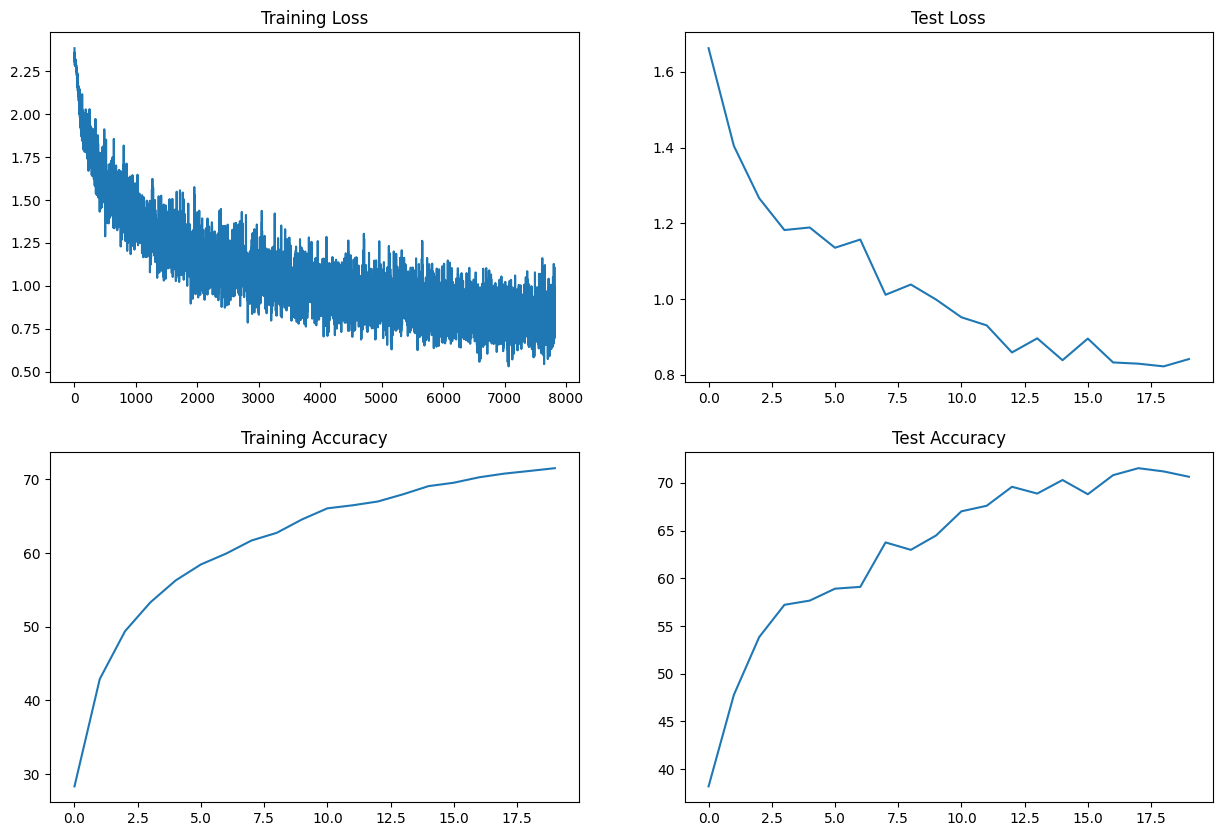

In [84]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)

# Model Params for Layer Normalization

In [85]:
from model import LN_Net

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = LN_Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 30, 30]             108
         LayerNorm-2            [-1, 4, 30, 30]           7,200
           Dropout-3            [-1, 4, 30, 30]               0
              ReLU-4            [-1, 4, 30, 30]               0
            Conv2d-5            [-1, 4, 28, 28]             144
         LayerNorm-6            [-1, 4, 28, 28]           6,272
           Dropout-7            [-1, 4, 28, 28]               0
              ReLU-8            [-1, 4, 28, 28]               0
            Conv2d-9            [-1, 4, 28, 28]              16
             ReLU-10            [-1, 4, 28, 28]               0
        MaxPool2d-11            [-1, 4, 14, 14]               0
           Conv2d-12            [-1, 8, 14, 14]             288
        LayerNorm-13            [-1, 8, 14, 14]           3,136
          Dropout-14            [-1, 8,

# Training and Testing for Layer Normalization

In [86]:
train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []

model =  LN_Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


Loss=1.8017756938934326 Batch_id=390 Accuracy=20.73: 100%|██████████| 391/391 [00:20<00:00, 19.28it/s]



Test set: Average loss: 1.8812, Accuracy: 2779/10000 (27.79%)

EPOCH: 1


Loss=1.9097992181777954 Batch_id=390 Accuracy=31.21: 100%|██████████| 391/391 [00:19<00:00, 19.81it/s]



Test set: Average loss: 1.7447, Accuracy: 3515/10000 (35.15%)

EPOCH: 2


Loss=1.9288866519927979 Batch_id=390 Accuracy=35.96: 100%|██████████| 391/391 [00:20<00:00, 19.45it/s]



Test set: Average loss: 1.6286, Accuracy: 3964/10000 (39.64%)

EPOCH: 3


Loss=1.6134510040283203 Batch_id=390 Accuracy=39.35: 100%|██████████| 391/391 [00:20<00:00, 18.84it/s]



Test set: Average loss: 1.5533, Accuracy: 4300/10000 (43.00%)

EPOCH: 4


Loss=1.7205078601837158 Batch_id=390 Accuracy=41.64: 100%|██████████| 391/391 [00:19<00:00, 19.99it/s]



Test set: Average loss: 1.5444, Accuracy: 4319/10000 (43.19%)

EPOCH: 5


Loss=1.4792736768722534 Batch_id=390 Accuracy=43.81: 100%|██████████| 391/391 [00:19<00:00, 20.47it/s]



Test set: Average loss: 1.4864, Accuracy: 4572/10000 (45.72%)

EPOCH: 6


Loss=1.5500812530517578 Batch_id=390 Accuracy=46.02: 100%|██████████| 391/391 [00:20<00:00, 19.38it/s]



Test set: Average loss: 1.4174, Accuracy: 4868/10000 (48.68%)

EPOCH: 7


Loss=1.3656806945800781 Batch_id=390 Accuracy=48.20: 100%|██████████| 391/391 [00:20<00:00, 18.79it/s]



Test set: Average loss: 1.4179, Accuracy: 4847/10000 (48.47%)

EPOCH: 8


Loss=1.3986473083496094 Batch_id=390 Accuracy=48.72: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s]



Test set: Average loss: 1.3277, Accuracy: 5198/10000 (51.98%)

EPOCH: 9


Loss=1.453197717666626 Batch_id=390 Accuracy=50.24: 100%|██████████| 391/391 [00:19<00:00, 20.29it/s]



Test set: Average loss: 1.3242, Accuracy: 5278/10000 (52.78%)

EPOCH: 10


Loss=1.1494717597961426 Batch_id=390 Accuracy=50.81: 100%|██████████| 391/391 [00:20<00:00, 19.13it/s]



Test set: Average loss: 1.2772, Accuracy: 5478/10000 (54.78%)

EPOCH: 11


Loss=0.9674667119979858 Batch_id=390 Accuracy=51.97: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s]



Test set: Average loss: 1.2849, Accuracy: 5403/10000 (54.03%)

EPOCH: 12


Loss=1.308672547340393 Batch_id=390 Accuracy=52.72: 100%|██████████| 391/391 [00:18<00:00, 20.70it/s]



Test set: Average loss: 1.2550, Accuracy: 5486/10000 (54.86%)

EPOCH: 13


Loss=1.4104260206222534 Batch_id=390 Accuracy=53.29: 100%|██████████| 391/391 [00:19<00:00, 19.83it/s]



Test set: Average loss: 1.2224, Accuracy: 5656/10000 (56.56%)

EPOCH: 14


Loss=1.068982720375061 Batch_id=390 Accuracy=54.45: 100%|██████████| 391/391 [00:19<00:00, 19.57it/s]



Test set: Average loss: 1.1945, Accuracy: 5755/10000 (57.55%)

EPOCH: 15


Loss=1.2430870532989502 Batch_id=390 Accuracy=54.94: 100%|██████████| 391/391 [00:18<00:00, 20.70it/s]



Test set: Average loss: 1.1947, Accuracy: 5781/10000 (57.81%)

EPOCH: 16


Loss=1.0847243070602417 Batch_id=390 Accuracy=55.41: 100%|██████████| 391/391 [00:20<00:00, 19.37it/s]



Test set: Average loss: 1.1409, Accuracy: 5979/10000 (59.79%)

EPOCH: 17


Loss=1.0781185626983643 Batch_id=390 Accuracy=56.22: 100%|██████████| 391/391 [00:19<00:00, 20.46it/s]



Test set: Average loss: 1.1633, Accuracy: 5864/10000 (58.64%)

EPOCH: 18


Loss=1.3325835466384888 Batch_id=390 Accuracy=55.99: 100%|██████████| 391/391 [00:18<00:00, 20.73it/s]



Test set: Average loss: 1.1421, Accuracy: 5954/10000 (59.54%)

EPOCH: 19


Loss=1.0834896564483643 Batch_id=390 Accuracy=56.97: 100%|██████████| 391/391 [00:20<00:00, 19.08it/s]



Test set: Average loss: 1.1574, Accuracy: 5925/10000 (59.25%)



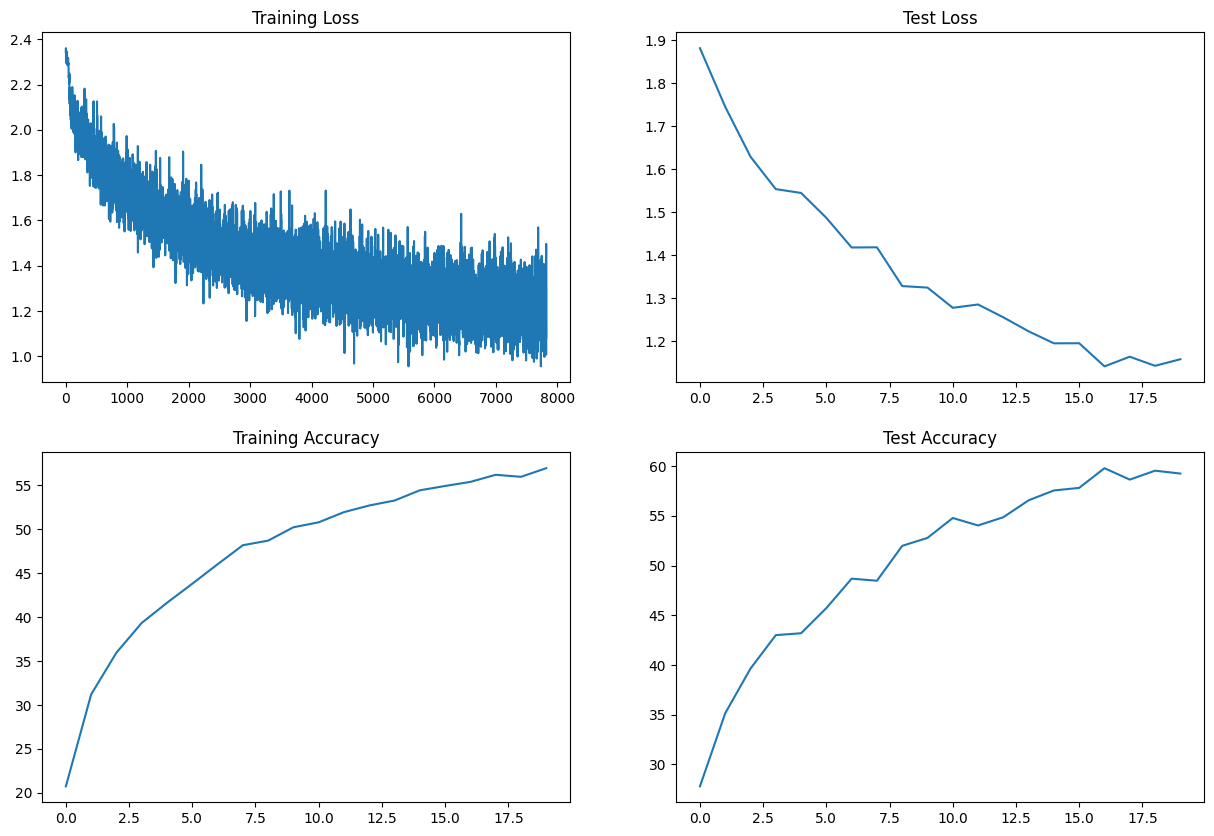

In [87]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)

# Model Params for Batch Normalization

In [14]:
from model import BN_Net

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = BN_Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
           Dropout-3           [-1, 16, 32, 32]               0
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
           Dropout-7           [-1, 32, 32, 32]               0
              ReLU-8           [-1, 32, 32, 32]               0
            Conv2d-9            [-1, 8, 34, 34]             256
             ReLU-10            [-1, 8, 34, 34]               0
        MaxPool2d-11            [-1, 8, 17, 17]               0
           Conv2d-12           [-1, 16, 15, 15]           1,152
      BatchNorm2d-13           [-1, 16, 15, 15]              32
          Dropout-14           [-1, 16,

# Training and Testing Batch Normalisation


In [15]:
train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []

model =  BN_Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


Loss=1.3812127113342285 Batch_id=390 Accuracy=36.53: 100%|██████████| 391/391 [00:20<00:00, 18.70it/s]



Test set: Average loss: 1.4740, Accuracy: 4525/10000 (45.25%)

EPOCH: 1


Loss=1.121417760848999 Batch_id=390 Accuracy=52.72: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s]



Test set: Average loss: 1.2530, Accuracy: 5518/10000 (55.18%)

EPOCH: 2


Loss=1.2050350904464722 Batch_id=390 Accuracy=58.71: 100%|██████████| 391/391 [00:21<00:00, 18.41it/s]



Test set: Average loss: 1.2982, Accuracy: 5422/10000 (54.22%)

EPOCH: 3


Loss=0.8435695767402649 Batch_id=390 Accuracy=61.74: 100%|██████████| 391/391 [00:19<00:00, 19.81it/s]



Test set: Average loss: 1.0620, Accuracy: 6233/10000 (62.33%)

EPOCH: 4


Loss=1.0000797510147095 Batch_id=390 Accuracy=63.64: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]



Test set: Average loss: 1.0013, Accuracy: 6390/10000 (63.90%)

EPOCH: 5


Loss=1.0776965618133545 Batch_id=390 Accuracy=65.57: 100%|██████████| 391/391 [00:20<00:00, 19.25it/s]



Test set: Average loss: 0.9636, Accuracy: 6534/10000 (65.34%)

EPOCH: 6


Loss=0.9029563665390015 Batch_id=390 Accuracy=66.70: 100%|██████████| 391/391 [00:18<00:00, 20.73it/s]



Test set: Average loss: 1.0431, Accuracy: 6363/10000 (63.63%)

EPOCH: 7


Loss=0.9110878705978394 Batch_id=390 Accuracy=67.62: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]



Test set: Average loss: 0.9606, Accuracy: 6567/10000 (65.67%)

EPOCH: 8


Loss=0.8026168942451477 Batch_id=390 Accuracy=68.89: 100%|██████████| 391/391 [00:19<00:00, 19.95it/s]



Test set: Average loss: 0.9028, Accuracy: 6768/10000 (67.68%)

EPOCH: 9


Loss=0.6446446180343628 Batch_id=390 Accuracy=69.65: 100%|██████████| 391/391 [00:18<00:00, 21.15it/s]



Test set: Average loss: 0.9046, Accuracy: 6841/10000 (68.41%)

EPOCH: 10


Loss=0.7288192510604858 Batch_id=390 Accuracy=70.38: 100%|██████████| 391/391 [00:20<00:00, 18.78it/s]



Test set: Average loss: 0.8157, Accuracy: 7114/10000 (71.14%)

EPOCH: 11


Loss=1.1101032495498657 Batch_id=390 Accuracy=70.94: 100%|██████████| 391/391 [00:19<00:00, 19.87it/s]



Test set: Average loss: 0.8714, Accuracy: 6953/10000 (69.53%)

EPOCH: 12


Loss=0.8794087171554565 Batch_id=390 Accuracy=71.70: 100%|██████████| 391/391 [00:18<00:00, 21.29it/s]



Test set: Average loss: 0.8504, Accuracy: 6937/10000 (69.37%)

EPOCH: 13


Loss=0.9828304052352905 Batch_id=390 Accuracy=72.39: 100%|██████████| 391/391 [00:20<00:00, 19.32it/s]



Test set: Average loss: 0.7575, Accuracy: 7352/10000 (73.52%)

EPOCH: 14


Loss=0.7870365977287292 Batch_id=390 Accuracy=72.54: 100%|██████████| 391/391 [00:18<00:00, 21.19it/s]



Test set: Average loss: 0.7692, Accuracy: 7306/10000 (73.06%)

EPOCH: 15


Loss=0.8838998675346375 Batch_id=390 Accuracy=73.13: 100%|██████████| 391/391 [00:20<00:00, 18.87it/s]



Test set: Average loss: 0.7966, Accuracy: 7208/10000 (72.08%)

EPOCH: 16


Loss=0.8366786241531372 Batch_id=390 Accuracy=73.64: 100%|██████████| 391/391 [00:19<00:00, 20.44it/s]



Test set: Average loss: 0.7807, Accuracy: 7300/10000 (73.00%)

EPOCH: 17


Loss=0.8088863492012024 Batch_id=390 Accuracy=73.85: 100%|██████████| 391/391 [00:19<00:00, 20.46it/s]



Test set: Average loss: 0.7726, Accuracy: 7282/10000 (72.82%)

EPOCH: 18


Loss=0.5990673303604126 Batch_id=390 Accuracy=74.14: 100%|██████████| 391/391 [00:20<00:00, 19.15it/s]



Test set: Average loss: 0.8026, Accuracy: 7199/10000 (71.99%)

EPOCH: 19


Loss=0.7304026484489441 Batch_id=390 Accuracy=74.32: 100%|██████████| 391/391 [00:19<00:00, 20.45it/s]



Test set: Average loss: 0.7253, Accuracy: 7477/10000 (74.77%)



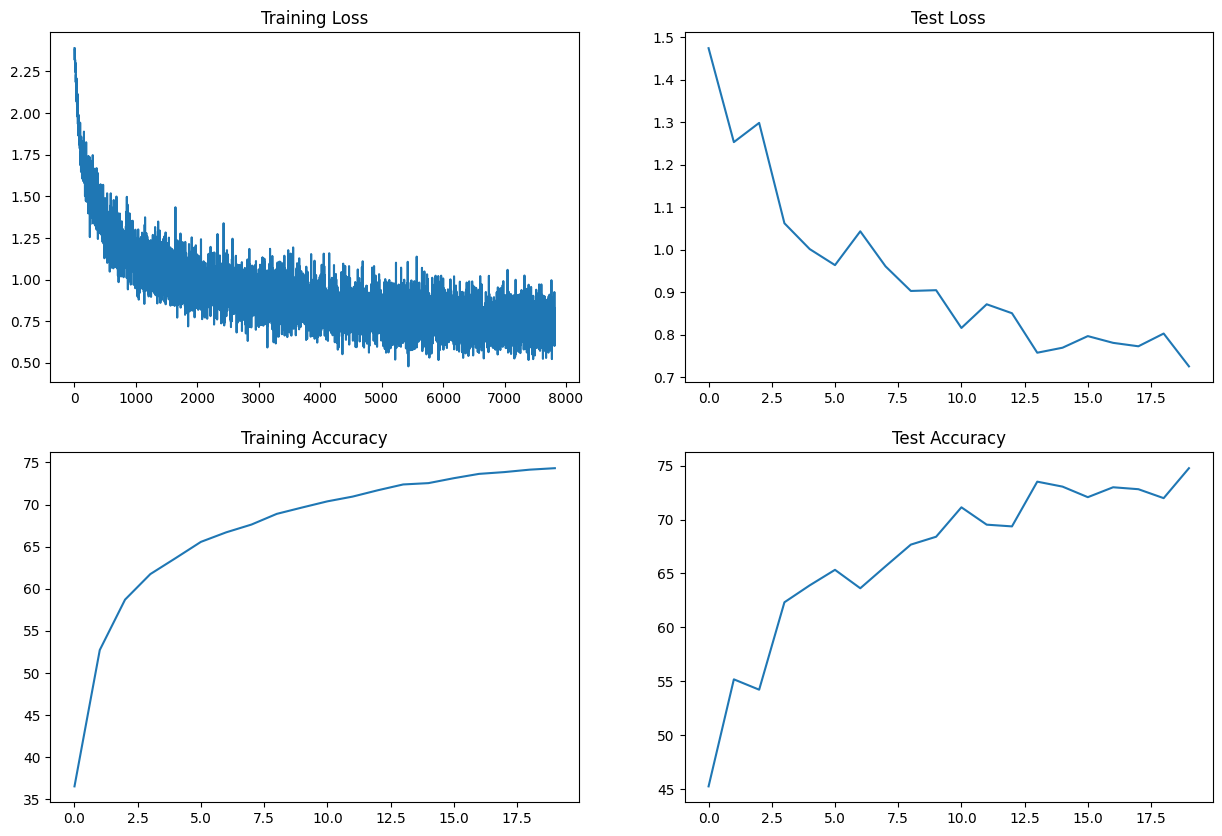

In [16]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)

## Printing some misclassified Images for BN

In [75]:
incorrect_examples = []
incorrect_labels = []
incorrect_pred = []
model.eval()
for data,target in test_loader:

  data , target = data.to(device), target.to(device)
  output = model(data) # shape = torch.Size([batch_size, 10])
  pred = output.argmax(dim=1, keepdim=True) #pred will be a 2d tensor of shape [batch_size,1]
  idxs_mask = ((pred == target.view_as(pred))==False).view(-1)
  if idxs_mask.numel(): #if index masks is non-empty append the correspoding data value in incorrect examples
    incorrect_examples.append(data[idxs_mask].squeeze().cpu().numpy()) #
    incorrect_labels.append(target[idxs_mask].cpu().numpy())# #the corresponding target to the misclassified image
    incorrect_pred.append(pred[idxs_mask].squeeze().cpu().numpy()) ##the corresponiding predicted class of the misclassified image

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


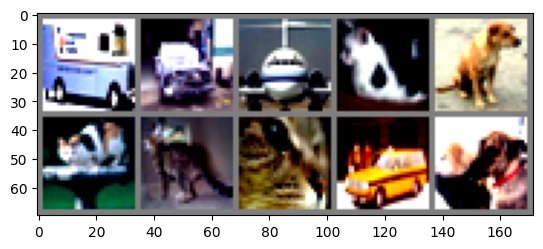

The correct labels are:  truck car   plane cat   dog   cat   cat   cat   car   dog  
The incorrect labels are:  car   truck ship  dog   deer  ship  deer  bird  truck cat  


In [78]:
# Let's visualize some of the images
def num_imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

num_imshow(utils.make_grid(torch.from_numpy(incorrect_examples[0][:10]), nrow=5))
# print labels
print('The correct labels are: ',' '.join(f'{classes[incorrect_labels[0][i]]:5s}' for i in range(10)))
print('The incorrect labels are: ',' '.join(f'{classes[incorrect_pred[0][i]]:5s}' for i in range(10)))

### Example 2 of misclassified images

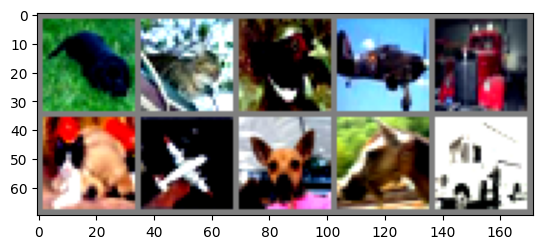

The correct labels are:  dog   cat   bird  plane truck cat   plane dog   horse truck
The incorrect labels are:  bird  frog  cat   truck deer  dog   bird  deer  bird  horse


In [80]:
num_imshow(utils.make_grid(torch.from_numpy(incorrect_examples[0][10:20]), nrow=5))
# print labels
print('The correct labels are: ',' '.join(f'{classes[incorrect_labels[0][i]]:5s}' for i in range(10,20)))
print('The incorrect labels are: ',' '.join(f'{classes[incorrect_pred[0][i]]:5s}' for i in range(10,20)))

### Example 3 of misclassified images

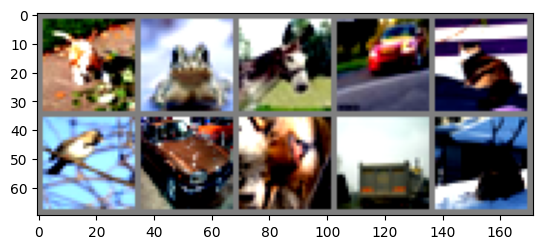

The correct labels are:  dog   frog  horse car   cat   bird  car   cat   truck deer 
The incorrect labels are:  deer  dog   cat   frog  plane plane frog  dog   ship  car  


In [81]:
num_imshow(utils.make_grid(torch.from_numpy(incorrect_examples[0][20:30]), nrow=5))
# print labels
print('The correct labels are: ',' '.join(f'{classes[incorrect_labels[0][i]]:5s}' for i in range(20,30)))
print('The incorrect labels are: ',' '.join(f'{classes[incorrect_pred[0][i]]:5s}' for i in range(20,30)))